# Implementing a bayesian normative model for cortical thickness using PYMC with ADVI

---

### package imports and basic functions

---

In [1]:
import os
import gc
import sys
import glob
import json
import random
import datetime
import importlib
import itertools
import numpy as np
from scipy import spatial
import scipy.sparse as sparse
import scipy.stats as stats
import pandas as pd
import nibabel as nib
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import boto3


In [2]:
# pymc libraries
import pymc as pm
import arviz as az
import xarray as xr
import patsy

print(f"Running on PyMC v{pm.__version__}")


Running on PyMC v4.2.2


In [3]:
class MyNumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(MyEncoder, self).default(obj)


def ensure_dir(file_name):
    os.makedirs(os.path.dirname(file_name), exist_ok=True)
    return file_name


def list_dirs(path=os.getcwd()):
    files = glob.glob(os.path.join(path, '*'))
    files = [x for x in files if os.path.isdir(x)]
    return files


def file_exists(file_name, path_name=os.getcwd()):
    return os.path.isfile(os.path.join(path_name, file_name))


def write_json(json_obj, file_path):
    with open(file_path, 'w') as outfile:
        json.dump(json_obj, outfile, sort_keys=True, indent=4,
                  cls=MyNumpyEncoder)
    return json_obj


def load_json(file_path):
    with open(file_path, 'r') as infile:
        return json.load(infile)


def write_np(np_obj, file_path):
    with open(file_path, 'wb') as outfile:
        np.save(outfile, np_obj)


def load_np(file_path):
    with open(file_path, 'rb') as infile:
        return np.load(infile)


In [4]:
# path setting
main_dir = os.path.abspath('../../../..')
main_dir


'/mountpoint/code/projects/normative_brain_charts'

## Load aggregated data

---

In [5]:
demography_df = pd.read_csv(f'{main_dir}/data/csv/demography_all_datasets.csv', index_col=0)


## Make two dummy thickness variables that are correlated

---

In [38]:
# thickness_vars.var(0)
np.cov(thickness_vars.T)
# np.corrcoef(thickness_vars.T)
Ell_rot.shape
Ell.shape
R_rot.dot(Ell).shape

(2, 100)

[[1.         0.52365389]
 [0.52365389 1.        ]]


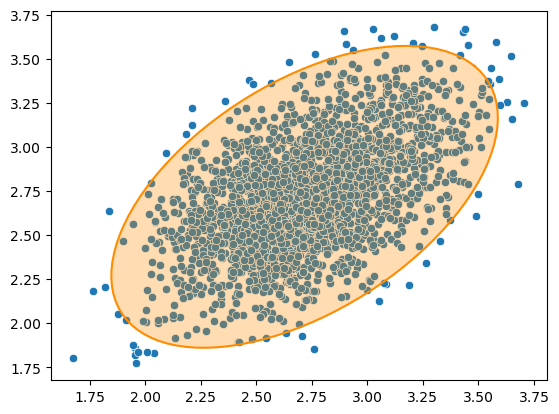

In [544]:
from matplotlib.patches import Ellipse

thickness_vars = np.random.normal(scale=demography_df['thickness'].values.std(), size=(demography_df.shape[0], 2))
thickness_vars = (thickness_vars.T + 1.0 * demography_df['thickness'].values).T

print(np.corrcoef(thickness_vars.T))

Sigma_actual = np.cov(thickness_vars.T)
var, U = np.linalg.eig(Sigma_actual)
angle = np.arccos(np.abs(U[0, 0]))

def plot_ellipse(x_center, y_center, x_radius, y_radius, rotation_angle, ax, color='darkorange'):
    u, v, a, b, t_rot = x_center, y_center, x_radius, y_radius, rotation_angle
    
    t = np.linspace(0, 2*np.pi, 100)
    Ell = np.array([a*np.cos(t) , b*np.sin(t)])
    R_rot = np.array([[np.cos(t_rot) , -np.sin(t_rot)],[np.sin(t_rot) , np.cos(t_rot)]])
    Ell_rot = R_rot.dot(Ell)
    
    ax.plot(u + Ell_rot[0,:], v + Ell_rot[1,:], color)
    ax.fill(u + Ell_rot[0,:], v + Ell_rot[1,:], color, alpha=0.3)

ax = sns.scatterplot(x=thickness_vars[:,0], y=thickness_vars[:,1])

plot_ellipse(thickness_vars[:,0].mean(), thickness_vars[:,1].mean(), 2 * np.sqrt(1.96 * var[0]), 2 * np.sqrt(1.96 * var[1]), angle, ax)

demography_df[['thickness_v1', 'thickness_v2']] = thickness_vars


## Fit a hierarchical bayesian model with PYMC + ADVI

---

Hierarchical Bayesian Regression (HBR) is capable of modeling site variations as a random stochastic effect with a prior distribution. In contrast to MCMC, ADVI ([Automatic Differentiation Variational Inference](https://docs.pymc.io/en/latest/api/generated/pymc.ADVI.html)) provides an approximate solution to the problem but is significantly faster and provides relatively accurate estimates.

The model below implements a nonlinear variation of thickness by age with intercepts that are influenced by site and sex. The model assumes a normal distribution for thickness. Mean and variance are considered model variables that are fitted by observations. Mean and variance are considered to be affected by age, gender, and sex. 

Furthermore, we try to model codependence between two alternative thickness measures (could represent two correlated thickness eigenmodes). The codepndence is modeled by a multivariate (bivariate) normal distribution and the covariance is considered to be affected by age, gender, and sex.


In [545]:
%%time
# smaller sample for faster convergence
# sample_df = all_df.sample(200, random_state=1)
sample_df = demography_df

# Data preperation
age = sample_df['age'].values
age_standardized = (age - age.mean()) / age.std()
thickness = sample_df['thickness_v1'].values
thickness_standardized = (thickness - thickness.mean()) / thickness.std()
site_idxs, sites = pd.factorize(sample_df['dataset'])
sex_idxs, sexes = pd.factorize(sample_df['sex'])
   
# Splines to model nonlinear age effects on thickness
# number of spline nuts (could be tuned)
num_knots = 3
knot_list = np.quantile(age_standardized, np.linspace(0, 1, num_knots))
# create b spline basis for regression using patsy
B_spline_age = patsy.dmatrix(
    "bs(age_standardized, knots=knots, degree=3, include_intercept=True) - 1",
    {"age_standardized": age_standardized, "knots": knot_list[1:-1]},
)

coords = {
    "site": sites,
    "sex": sexes,
    "splines": np.arange(B_spline_age.shape[1]),
    "obs_id": np.arange(len(site_idxs)),
}

advi_model_v1 = pm.Model(coords=coords)

# a nonlinear spline model (see https://www.pymc.io/projects/examples/en/latest/case_studies/spline.html)
with advi_model_v1:
    # minibatch variables
    age_standardized_t = pm.Minibatch(age_standardized, 100,)
    sex_idx_t = pm.Minibatch(sex_idxs, 100)
    site_idx_t = pm.Minibatch(site_idxs, 100)
    B_spline_age_t = pm.Minibatch(B_spline_age, 100)
    thickness_standardized_t = pm.Minibatch(thickness_standardized, 100)
    
    # Hyperpriors for site groups (as if we have random group effects)
    mu_intercept_site = pm.Normal('mu_intercept_site', mu=0, sigma=10)
    sigma_intercept_site = pm.HalfNormal("sigma_intercept_site", sigma=10)
    sigma_error_site = pm.HalfNormal("sigma_error_site", sigma=10)

    # Priors    
    # sex effects (similar to fixed sex effects (intercept only))
    intercept_sex = pm.Normal("intercept_sex", mu=0, sigma=10, dims="sex")
    
    # site effects (similar to random site effects (intercept only))
    #a_site = pm.Normal("a_site", mu=mu_a_site, sigma=sigma_a_site, dims="site")
    intercept_site_offset = pm.Normal("intercept_site_offset", mu=0, sigma=1, dims="site")
    intercept_site = pm.Deterministic("intercept_site", mu_intercept_site + intercept_site_offset * sigma_intercept_site, dims="site")
    
    # age splines
    w_age = pm.Normal("w_age", mu=0, sigma=10, size=B_spline_age.shape[1], dims="splines")
    
    # Estimated thickness
    thickness_est = pm.Deterministic("thickness_est", intercept_sex[sex_idx_t] + intercept_site[site_idx_t] + pm.math.dot(B_spline_age_t, w_age.T))

    # Model error
    # nonlinear age error
    w_error_age = pm.HalfCauchy("w_error_age", beta=5, size=B_spline_age.shape[1], dims="splines")
    
    # constant sex error
    error_sex = pm.HalfCauchy("error_sex", beta=5, dims="sex")
    
    # random site error
    error_site_offset = pm.HalfCauchy("error_site_offset", beta=5, dims="site")
    error_site = pm.Deterministic("error_site", error_site_offset * sigma_error_site, dims="site")
    
    # Error estimate
    thickness_error = pm.Deterministic("thickness_error", error_sex[sex_idx_t] + error_site[site_idx_t] + pm.math.dot(B_spline_age_t, w_error_age.T))
    
    # Skewness estimate
    # thickness_skewness = pm.Normal("thickness_skewness", mu=0, sigma=10, total_size=len(sample_df))
    #thickness_skewness = pm.Normal("thickness_skewness", mu=0, sigma=10, total_size=len(sample_df))
    
    # Likelihood (sampling distribution) of observations
    # need to figure out how to bound the distribution
#     pm.Bound("thickness_like", pm.Normal, lower=(-thickness.mean() / thickness.std()))(
    # thickness_like = pm.SkewNormal(
    thickness_like = pm.Normal(
        "thickness_like",
        mu=thickness_est,
        sigma=thickness_error,
        observed=thickness_standardized_t,
        total_size=len(sample_df),
    )
        # alpha=thickness_skewness,
    
    # run ADVI with minibatch
    error_approx_v1 = pm.fit(100000, callbacks=[pm.callbacks.CheckParametersConvergence(tolerance=1e-4)])
    
    # sample from trace
    advi_model_idata_v1 = pm.sample_prior_predictive()
    advi_model_idata_v1.extend(error_approx_v1.sample(2000))
    pm.sample_posterior_predictive(advi_model_idata_v1, extend_inferencedata=True)


Finished [100%]: Average Loss = 119.57
Sampling: [error_sex, error_site_offset, intercept_sex, intercept_site_offset, mu_intercept_site, sigma_error_site, sigma_intercept_site, thickness_like, w_age, w_error_age]
/mountpoint/code/environments/pymc_env/lib/python3.10/site-packages/pymc/backends/arviz.py:56: UserWarning: Could not extract data from symbolic observation thickness_like
  warnings.warn(f"Could not extract data from symbolic observation {obs}")
/mountpoint/code/environments/pymc_env/lib/python3.10/site-packages/pymc/backends/arviz.py:56: UserWarning: Could not extract data from symbolic observation thickness_like
  warnings.warn(f"Could not extract data from symbolic observation {obs}")
Sampling: [thickness_like]


CPU times: user 1min 52s, sys: 542 ms, total: 1min 52s
Wall time: 1min 52s


/mountpoint/code/environments/pymc_env/lib/python3.10/site-packages/pymc/backends/arviz.py:56: UserWarning: Could not extract data from symbolic observation thickness_like
  warnings.warn(f"Could not extract data from symbolic observation {obs}")


In [546]:
%%time
# smaller sample for faster convergence
# sample_df = all_df.sample(200, random_state=1)
sample_df = demography_df

# Data preperation
age = sample_df['age'].values
age_standardized = (age - age.mean()) / age.std()
thickness = sample_df['thickness_v2'].values
thickness_standardized = (thickness - thickness.mean()) / thickness.std()
site_idxs, sites = pd.factorize(sample_df['dataset'])
sex_idxs, sexes = pd.factorize(sample_df['sex'])
   
# Splines to model nonlinear age effects on thickness
# number of spline nuts (could be tuned)
num_knots = 3
knot_list = np.quantile(age_standardized, np.linspace(0, 1, num_knots))
# create b spline basis for regression using patsy
B_spline_age = patsy.dmatrix(
    "bs(age_standardized, knots=knots, degree=3, include_intercept=True) - 1",
    {"age_standardized": age_standardized, "knots": knot_list[1:-1]},
)

coords = {
    "site": sites,
    "sex": sexes,
    "splines": np.arange(B_spline_age.shape[1]),
    "obs_id": np.arange(len(site_idxs)),
}

advi_model_v2 = pm.Model(coords=coords)

# a nonlinear spline model (see https://www.pymc.io/projects/examples/en/latest/case_studies/spline.html)
with advi_model_v2:
    # minibatch variables
    age_standardized_t = pm.Minibatch(age_standardized, 100,)
    sex_idx_t = pm.Minibatch(sex_idxs, 100)
    site_idx_t = pm.Minibatch(site_idxs, 100)
    B_spline_age_t = pm.Minibatch(B_spline_age, 100)
    thickness_standardized_t = pm.Minibatch(thickness_standardized, 100)
    
    # Hyperpriors for site groups (as if we have random group effects)
    mu_intercept_site = pm.Normal('mu_intercept_site', mu=0, sigma=10)
    sigma_intercept_site = pm.HalfNormal("sigma_intercept_site", sigma=10)
    sigma_error_site = pm.HalfNormal("sigma_error_site", sigma=10)

    # Priors    
    # sex effects (similar to fixed sex effects (intercept only))
    intercept_sex = pm.Normal("intercept_sex", mu=0, sigma=10, dims="sex")
    
    # site effects (similar to random site effects (intercept only))
    #a_site = pm.Normal("a_site", mu=mu_a_site, sigma=sigma_a_site, dims="site")
    intercept_site_offset = pm.Normal("intercept_site_offset", mu=0, sigma=1, dims="site")
    intercept_site = pm.Deterministic("intercept_site", mu_intercept_site + intercept_site_offset * sigma_intercept_site, dims="site")
    
    # age splines
    w_age = pm.Normal("w_age", mu=0, sigma=10, size=B_spline_age.shape[1], dims="splines")
    
    # Estimated thickness
    thickness_est = pm.Deterministic("thickness_est", intercept_sex[sex_idx_t] + intercept_site[site_idx_t] + pm.math.dot(B_spline_age_t, w_age.T))

    # Model error
    # nonlinear age error
    w_error_age = pm.HalfCauchy("w_error_age", beta=5, size=B_spline_age.shape[1], dims="splines")
    
    # constant sex error
    error_sex = pm.HalfCauchy("error_sex", beta=5, dims="sex")
    
    # random site error
    error_site_offset = pm.HalfCauchy("error_site_offset", beta=5, dims="site")
    error_site = pm.Deterministic("error_site", error_site_offset * sigma_error_site, dims="site")
    
    # Error estimate
    thickness_error = pm.Deterministic("thickness_error", error_sex[sex_idx_t] + error_site[site_idx_t] + pm.math.dot(B_spline_age_t, w_error_age.T))
    
    # Skewness estimate
    # thickness_skewness = pm.Normal("thickness_skewness", mu=0, sigma=10, total_size=len(sample_df))
    #thickness_skewness = pm.Normal("thickness_skewness", mu=0, sigma=10, total_size=len(sample_df))
    
    # Likelihood (sampling distribution) of observations
    # need to figure out how to bound the distribution
#     pm.Bound("thickness_like", pm.Normal, lower=(-thickness.mean() / thickness.std()))(
    # thickness_like = pm.SkewNormal(
    thickness_like = pm.Normal(
        "thickness_like",
        mu=thickness_est,
        sigma=thickness_error,
        observed=thickness_standardized_t,
        total_size=len(sample_df),
    )
        # alpha=thickness_skewness,
    
    # run ADVI with minibatch
    error_approx_v2 = pm.fit(100000, callbacks=[pm.callbacks.CheckParametersConvergence(tolerance=1e-4)])
    
    # sample from trace
    advi_model_idata_v2 = pm.sample_prior_predictive()
    advi_model_idata_v2.extend(error_approx_v2.sample(2000))
    pm.sample_posterior_predictive(advi_model_idata_v2, extend_inferencedata=True)


Finished [100%]: Average Loss = 118.68
Sampling: [error_sex, error_site_offset, intercept_sex, intercept_site_offset, mu_intercept_site, sigma_error_site, sigma_intercept_site, thickness_like, w_age, w_error_age]
/mountpoint/code/environments/pymc_env/lib/python3.10/site-packages/pymc/backends/arviz.py:56: UserWarning: Could not extract data from symbolic observation thickness_like
  warnings.warn(f"Could not extract data from symbolic observation {obs}")
/mountpoint/code/environments/pymc_env/lib/python3.10/site-packages/pymc/backends/arviz.py:56: UserWarning: Could not extract data from symbolic observation thickness_like
  warnings.warn(f"Could not extract data from symbolic observation {obs}")
Sampling: [thickness_like]


CPU times: user 1min 58s, sys: 461 ms, total: 1min 58s
Wall time: 1min 58s


/mountpoint/code/environments/pymc_env/lib/python3.10/site-packages/pymc/backends/arviz.py:56: UserWarning: Could not extract data from symbolic observation thickness_like
  warnings.warn(f"Could not extract data from symbolic observation {obs}")


## Visualise fitted centiles

---

CPU times: user 1.07 s, sys: 905 ms, total: 1.98 s
Wall time: 174 ms


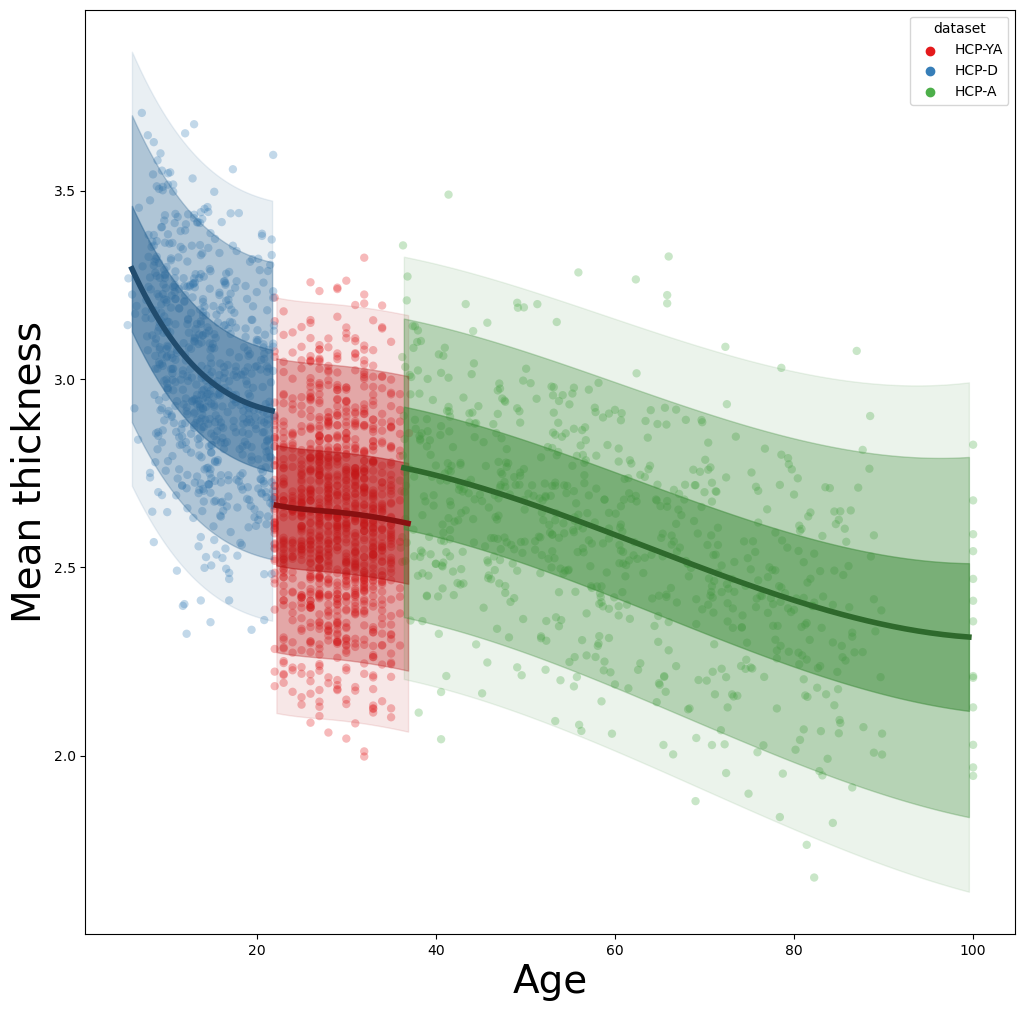

In [547]:
%%time

fig, ax = plt.subplots(1, 1, figsize=(12, 12))

sns.scatterplot(
    data=demography_df,
    x='age',
    y='thickness_v1',
    ax=ax,
    linewidth=0,
    hue='dataset',
    palette="Set1",
#     palette=mpl.cm.Set1,
    alpha = 0.3,
#     color=[0.3,0.6,0.9,0.5],
)

# ax.set_xlim(20,40)
# ax.set_ylim(2.2,3)

ax.set_xlabel('Age', fontsize=28)
ax.set_ylabel('Mean thickness', fontsize=28)

thickness = sample_df['thickness_v1'].values

for idx in np.unique(site_idxs):
    xi = xr.DataArray(np.linspace(np.min(age), np.max(age), 200), dims=["obs_id"])
    selection = (xi > np.min(age[site_idxs == idx])) & (xi < np.max(age[site_idxs == idx]))
    post = advi_model_idata_v1.posterior
    
    prediction_B_spline_age = patsy.dmatrix(
        "bs(xi, knots=knots, degree=3, include_intercept=True) - 1",
        {"xi": ((xi - age.mean()) / age.std()), "knots": knot_list[1:-1]},
    )

    y_ppc_mu = (
        post['intercept_sex'].stack(sample=("chain", "draw"))[0].data +
        post['intercept_site'].stack(sample=("chain", "draw"))[idx].data +
        np.dot(
            prediction_B_spline_age,
            post['w_age'].stack(sample=("chain", "draw"))
        )
    )

    y_ppc_sigma = (
        post['error_sex'].stack(sample=("chain", "draw"))[0].data +
        post['error_site'].stack(sample=("chain", "draw"))[idx].data +
        np.dot(
            prediction_B_spline_age,
            post['w_error_age'].stack(sample=("chain", "draw"))
        )
    )

    # y_ppc_alpha = post['thickness_skewness'].stack(sample=("chain", "draw")).data
    
    # need to ensure the correctness
    quantiles = [0.01, 0.05, 0.25, 0.50, 0.75, 0.95, 0.99]
    
    thickness_quantiles = {
        q: (
            (
                y_ppc_mu.mean(1) + stats.norm.ppf(q=q) * y_ppc_sigma.mean(1)
            )  * thickness.std() +
            thickness.mean()
        ) for q in quantiles
    }

    # centile plot
    for q1, q2, alpha in [(0.01, 0.99, 0.1), (0.05, 0.95, 0.3), (0.25, 0.75, 0.5)]:
        ax.fill_between(
            xi[selection],
            thickness_quantiles[q1][selection],
            thickness_quantiles[q2][selection],
            alpha=alpha,
            color=np.array(mpl.cm.Set1(idx)[:3])*0.8,
        )
    
    ax.plot(
        xi[selection],
        thickness_quantiles[0.5][selection],
        c=np.array(mpl.cm.Set1(idx)[:3])*0.6,
        lw=4,
    )


CPU times: user 973 ms, sys: 949 ms, total: 1.92 s
Wall time: 176 ms


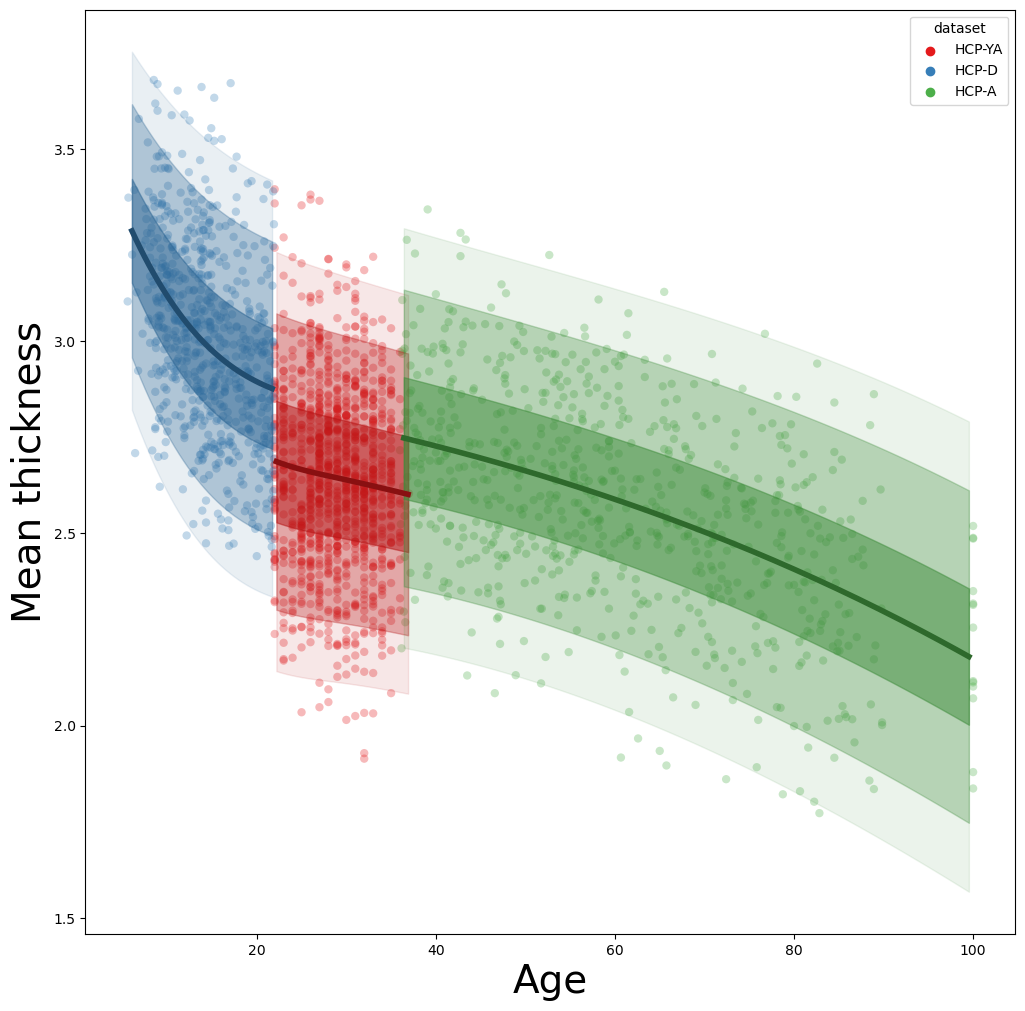

In [548]:
%%time

fig, ax = plt.subplots(1, 1, figsize=(12, 12))

sns.scatterplot(
    data=demography_df,
    x='age',
    y='thickness_v2',
    ax=ax,
    linewidth=0,
    hue='dataset',
    palette="Set1",
#     palette=mpl.cm.Set1,
    alpha = 0.3,
#     color=[0.3,0.6,0.9,0.5],
)

# ax.set_xlim(20,40)
# ax.set_ylim(2.2,3)

ax.set_xlabel('Age', fontsize=28)
ax.set_ylabel('Mean thickness', fontsize=28)

thickness = sample_df['thickness_v2'].values

for idx in np.unique(site_idxs):
    xi = xr.DataArray(np.linspace(np.min(age), np.max(age), 200), dims=["obs_id"])
    selection = (xi > np.min(age[site_idxs == idx])) & (xi < np.max(age[site_idxs == idx]))
    post = advi_model_idata_v2.posterior
    
    prediction_B_spline_age = patsy.dmatrix(
        "bs(xi, knots=knots, degree=3, include_intercept=True) - 1",
        {"xi": ((xi - age.mean()) / age.std()), "knots": knot_list[1:-1]},
    )

    y_ppc_mu = (
        post['intercept_sex'].stack(sample=("chain", "draw"))[0].data +
        post['intercept_site'].stack(sample=("chain", "draw"))[idx].data +
        np.dot(
            prediction_B_spline_age,
            post['w_age'].stack(sample=("chain", "draw"))
        )
    )

    y_ppc_sigma = (
        post['error_sex'].stack(sample=("chain", "draw"))[0].data +
        post['error_site'].stack(sample=("chain", "draw"))[idx].data +
        np.dot(
            prediction_B_spline_age,
            post['w_error_age'].stack(sample=("chain", "draw"))
        )
    )

    # y_ppc_alpha = post['thickness_skewness'].stack(sample=("chain", "draw")).data
    
    # need to ensure the correctness
    quantiles = [0.01, 0.05, 0.25, 0.50, 0.75, 0.95, 0.99]
    
    thickness_quantiles = {
        q: (
            (
                y_ppc_mu.mean(1) + stats.norm.ppf(q=q) * y_ppc_sigma.mean(1)
            )  * thickness.std() +
            thickness.mean()
        ) for q in quantiles
    }

    # centile plot
    for q1, q2, alpha in [(0.01, 0.99, 0.1), (0.05, 0.95, 0.3), (0.25, 0.75, 0.5)]:
        ax.fill_between(
            xi[selection],
            thickness_quantiles[q1][selection],
            thickness_quantiles[q2][selection],
            alpha=alpha,
            color=np.array(mpl.cm.Set1(idx)[:3])*0.8,
        )
    
    ax.plot(
        xi[selection],
        thickness_quantiles[0.5][selection],
        c=np.array(mpl.cm.Set1(idx)[:3])*0.6,
        lw=4,
    )


## Store the inference data

---

In [64]:
advi_model_idata_v1.to_netcdf(ensure_dir(f'{main_dir}/data/models/pymc/mean_thickness_advi_v1.nc'))


'/mountpoint/code/projects/normative_brain_charts/data/models/pymc/mean_thickness_advi_v1.nc'

In [65]:
advi_model_idata_v2.to_netcdf(ensure_dir(f'{main_dir}/data/models/pymc/mean_thickness_advi_v2.nc'))


'/mountpoint/code/projects/normative_brain_charts/data/models/pymc/mean_thickness_advi_v2.nc'

In [ ]:
# advi_model_idata.to_zarr(ensure_dir(f'{main_dir}/data/models/pymc/mean_thickness_advi.zarr'))


## Fit the covariance

---

We try to model codependence between two alternative thickness measures (could represent two correlated thickness eigenmodes). The codepndence is modeled by a multivariate (bivariate) normal distribution and the covariance is considered to be affected by age, gender, and sex.


In [110]:
# x = advi_model_idata_v1.posterior['intercept_sex'].stack(sample=("chain", "draw")).mean('sample')

# np.array(x)

# # advi_model_idata_v1
# x1 = advi_model_idata_v1.posterior['thickness_est'].stack(sample=("chain", "draw")).mean('sample')
# x2 = advi_model_idata_v2.posterior['thickness_est'].stack(sample=("chain", "draw")).mean('sample')

# [x1, x2]
# x1

# thickness_v1 = sample_df['thickness_v1'].values
# thickness_v1_standardized = (thickness_v1 - thickness_v1.mean()) / thickness_v1.std()
# thickness_v2 = sample_df['thickness_v2'].values
# thickness_v2_standardized = (thickness_v2 - thickness_v2.mean()) / thickness_v2.std()

np.concatenate([thickness_v1_standardized[:, np.newaxis], thickness_v2_standardized[:, np.newaxis]], axis=1).shape


(2473, 2)

In [113]:
pd.factorize(['a','b'])

(array([0, 1]), array(['a', 'b'], dtype=object))

In [206]:
%%time

import aesara.tensor as at

# smaller sample for faster convergence
# sample_df = all_df.sample(200, random_state=1)
sample_df = demography_df

# Data preperation
age = sample_df['age'].values
age_standardized = (age - age.mean()) / age.std()
thickness_v1 = sample_df['thickness_v1'].values
thickness_v1_standardized = (thickness_v1 - thickness_v1.mean()) / thickness_v1.std()
thickness_v2 = sample_df['thickness_v2'].values
thickness_v2_standardized = (thickness_v2 - thickness_v2.mean()) / thickness_v2.std()
thicknesses_standardized = np.concatenate([thickness_v1_standardized[:, np.newaxis], thickness_v2_standardized[:, np.newaxis]], axis=1)
site_idxs, sites = pd.factorize(sample_df['dataset'])
sex_idxs, sexes = pd.factorize(sample_df['sex'])
thickness_idxs, thicknesses = pd.factorize(['thickness_v1','thickness_v2'])
   
# Splines to model nonlinear age effects on thickness
# number of spline nuts (could be tuned)
num_knots = 3
knot_list = np.quantile(age_standardized, np.linspace(0, 1, num_knots))
# create b spline basis for regression using patsy
B_spline_age = patsy.dmatrix(
    "bs(age_standardized, knots=knots, degree=3, include_intercept=True) - 1",
    {"age_standardized": age_standardized, "knots": knot_list[1:-1]},
)

coords = {
    "site": sites,
    "sex": sexes,
    "splines": np.arange(B_spline_age.shape[1]),
    "obs_id": np.arange(len(site_idxs)),
}

advi_model_cov = pm.Model(coords=coords)

# a nonlinear spline model (see https://www.pymc.io/projects/examples/en/latest/case_studies/spline.html)
with advi_model_cov:
    # minibatch variables
    age_standardized_t = pm.Minibatch(age_standardized, 100,)
    sex_idx_t = pm.Minibatch(sex_idxs, 100)
    site_idx_t = pm.Minibatch(site_idxs, 100)
    B_spline_age_t = pm.Minibatch(B_spline_age, 100)
    # thickness_v1_standardized_t = pm.Minibatch(thickness_v1_standardized, 100)
    # thickness_v2_standardized_t = pm.Minibatch(thickness_v2_standardized, 100)
    thicknesses_standardized_t = pm.Minibatch(thicknesses_standardized, 100)
    
    # Hyperpriors for site groups (as if we have random group effects)
    mu_intercept_site_rho = pm.Normal('mu_intercept_site_rho', mu=0, sigma=10)
    sigma_intercept_site_rho = pm.HalfNormal("sigma_intercept_site_rho", sigma=10)
    # sigma_error_site_cov = pm.HalfNormal("sigma_error_site_cov", sigma=10)
    

    # Priors (for covariance/correlation)
    # sex effects (similar to fixed sex effects (intercept only))
    intercept_sex_rho = pm.Normal("intercept_sex_rho", mu=0, sigma=10, dims="sex")
    
    # site effects (similar to random site effects (intercept only))
    #a_site = pm.Normal("a_site", mu=mu_a_site, sigma=sigma_a_site, dims="site")
    intercept_site_offset_rho = pm.Normal("intercept_site_offset_rho", mu=0, sigma=1, dims="site")
    intercept_site_rho = pm.Deterministic("intercept_site_rho", mu_intercept_site_rho + intercept_site_offset_rho * sigma_intercept_site_rho, dims="site")
    
    # age splines
    w_age_rho = pm.Normal("w_age_rho", mu=0, sigma=10, size=B_spline_age.shape[1], dims="splines")
    
    # Estimated covariance/correlation
    rho_est = pm.Deterministic("rho_est", 2 * pm.math.sigmoid(intercept_sex_rho[sex_idx_t] + intercept_site_rho[site_idx_t] + pm.math.dot(B_spline_age_t, w_age_rho.T)) - 1)

#     # Model error
#     # nonlinear age error
#     w_error_age_cov = pm.Cauchy("w_error_age_cov", alpha=0, beta=5, size=B_spline_age.shape[1], dims="splines")
    
#     # constant sex error
#     error_sex_cov = pm.Cauchy("error_sex_cov", alpha=0, beta=5, dims="sex")
    
#     # random site error
#     error_site_offset_cov = pm.Cauchy("error_site_offset_cov", alpha=0, beta=5, dims="site")
#     error_site_cov = pm.Deterministic("error_site", error_site_offset_cov * sigma_error_site_cov, dims="site")
    
#     # Error estimate
#     thickness_error_cov = pm.Deterministic("thickness_error", error_sex[sex_idx_t] + error_site[site_idx_t] + pm.math.dot(B_spline_age_t, w_error_age.T))
    

    # Priors (constant priors, already fitted in previous models)
    # sex effects (similar to fixed sex effects (intercept only))
    # intercept_sex = pm.Normal("intercept_sex", mu=0, sigma=10, dims="sex")
    intercept_sex_v1 = pm.ConstantData("intercept_sex_v1", np.array(advi_model_idata_v1.posterior['intercept_sex'].stack(sample=("chain", "draw")).mean('sample')), dims="sex")
    intercept_sex_v2 = pm.ConstantData("intercept_sex_v2", np.array(advi_model_idata_v2.posterior['intercept_sex'].stack(sample=("chain", "draw")).mean('sample')), dims="sex")
    
    # site effects (similar to random site effects (intercept only))
    #a_site = pm.Normal("a_site", mu=mu_a_site, sigma=sigma_a_site, dims="site")
    # intercept_site_offset = pm.Normal("intercept_site_offset", mu=0, sigma=1, dims="site")
    # intercept_site = pm.Deterministic("intercept_site", mu_intercept_site + intercept_site_offset * sigma_intercept_site, dims="site")
    intercept_site_v1 = pm.ConstantData("intercept_site_v1", np.array(advi_model_idata_v1.posterior['intercept_site'].stack(sample=("chain", "draw")).mean('sample')), dims="site")
    intercept_site_v2 = pm.ConstantData("intercept_site_v2", np.array(advi_model_idata_v2.posterior['intercept_site'].stack(sample=("chain", "draw")).mean('sample')), dims="site")
    
    # age splines
    # w_age = pm.Normal("w_age", mu=0, sigma=10, size=B_spline_age.shape[1], dims="splines")
    w_age_v1 = pm.ConstantData("w_age_v1", np.array(advi_model_idata_v1.posterior['w_age'].stack(sample=("chain", "draw")).mean('sample')), dims="splines")
    w_age_v2 = pm.ConstantData("w_age_v2", np.array(advi_model_idata_v2.posterior['w_age'].stack(sample=("chain", "draw")).mean('sample')), dims="splines")
    
    # Estimated thickness
    # thickness_est = pm.Deterministic("thickness_est", intercept_sex[sex_idx_t] + intercept_site[site_idx_t] + pm.math.dot(B_spline_age_t, w_age.T))
    thickness_est_v1 = pm.Deterministic("thickness_est_v1", intercept_sex_v1[sex_idx_t] + intercept_site_v1[site_idx_t] + pm.math.dot(B_spline_age_t, w_age_v1.T))
    thickness_est_v2 = pm.Deterministic("thickness_est_v2", intercept_sex_v2[sex_idx_t] + intercept_site_v2[site_idx_t] + pm.math.dot(B_spline_age_t, w_age_v2.T))

    # Model error
    # nonlinear age error
    # w_error_age = pm.HalfCauchy("w_error_age", beta=5, size=B_spline_age.shape[1], dims="splines")
    w_error_age_v1 = pm.ConstantData("w_error_age_v1", np.array(advi_model_idata_v1.posterior['w_error_age'].stack(sample=("chain", "draw")).mean('sample')), dims="splines")
    w_error_age_v2 = pm.ConstantData("w_error_age_v2", np.array(advi_model_idata_v2.posterior['w_error_age'].stack(sample=("chain", "draw")).mean('sample')), dims="splines")
    
    # constant sex error
    # error_sex = pm.HalfCauchy("error_sex", beta=5, dims="sex")
    error_sex_v1 = pm.ConstantData("error_sex_v1", np.array(advi_model_idata_v1.posterior['error_sex'].stack(sample=("chain", "draw")).mean('sample')), dims="sex")
    error_sex_v2 = pm.ConstantData("error_sex_v2", np.array(advi_model_idata_v2.posterior['error_sex'].stack(sample=("chain", "draw")).mean('sample')), dims="sex")
    
    # random site error
    # error_site_offset = pm.HalfCauchy("error_site_offset", beta=5, dims="site")
    # error_site = pm.Deterministic("error_site", error_site_offset * sigma_error_site, dims="site")
    error_site_v1 = pm.ConstantData("error_site_v1", np.array(advi_model_idata_v1.posterior['error_site'].stack(sample=("chain", "draw")).mean('sample')), dims="site")
    error_site_v2 = pm.ConstantData("error_site_v2", np.array(advi_model_idata_v2.posterior['error_site'].stack(sample=("chain", "draw")).mean('sample')), dims="site")
    
    # Error estimate
    # thickness_error = pm.Deterministic("thickness_error", error_sex[sex_idx_t] + error_site[site_idx_t] + pm.math.dot(B_spline_age_t, w_error_age.T))
    thickness_error_v1 = pm.Deterministic("thickness_error_v1", error_sex_v1[sex_idx_t] + error_site_v1[site_idx_t] + pm.math.dot(B_spline_age_t, w_error_age_v1.T))
    thickness_error_v2 = pm.Deterministic("thickness_error_v2", error_sex_v2[sex_idx_t] + error_site_v2[site_idx_t] + pm.math.dot(B_spline_age_t, w_error_age_v2.T))
        
    # Likelihood (sampling distribution) of observations
    # Likelihood estimation from a bivariate normal with known mean and variance, but unknown covariance
    bivariate_mu = pm.Deterministic("bivariate_mu", at.stacklists([thickness_est_v1, thickness_est_v2]).T)
    # covariance_matrix = pm.Deterministic(
    #     "covariance_matrix",
    #     at.stacklists([[thickness_error_v1, cov_est], [cov_est, thickness_error_v2]]).T
    # )
    # instead of a covariance matrix, let's define a cholesky decomposition
    # see:
    # https://www.pymc.io/projects/docs/en/stable/api/distributions/generated/pymc.LKJCholeskyCov.html
    # https://www2.stat.duke.edu/courses/Spring12/sta104.1/Lectures/Lec22.pdf
    cholesky_decomposition = pm.Deterministic("cholesky_decomposition", at.stacklists([thickness_est_v1, at.math.mul(thickness_est_v2, rho_est), at.math.mul(thickness_est_v2, at.math.sqrt(1 - rho_est**2)),]).T)
    
    # MvNormal only accept one cov at a time, you need to construct 
    # each component one by one
    # (check https://discourse.pymc.io/t/mixed-multivariate-gauss-distribution/1017/3)
    
#     compdist = []
#     for i in range(100):
#         compdist.append(
#             pm.MvNormal.dist(
#                 mu=bivariate_mu[i], cov=covariance_matrix[i]
#             )
#         )

#     obs = pm.Mixture('likelihood', w, compdist, observed=dataSet1)
    
    likelihood = pm.MvNormal(
        "likelihood",
        mu=bivariate_mu,
        chol=cholesky_decomposition,
        observed=thicknesses_standardized_t,
        total_size=(100, 2),
    )
        # cov=covariance_matrix,
    print('model defined!')
        
    # run ADVI with minibatch
    error_approx_cov = pm.fit(100000, callbacks=[pm.callbacks.CheckParametersConvergence(tolerance=1e-4)])
    print('advi executed!')
    
    # sample from trace
    advi_model_idata_cov = pm.sample_prior_predictive()
    advi_model_idata_cov.extend(error_approx_cov.sample(2000))
    pm.sample_posterior_predictive(advi_model_idata_cov, extend_inferencedata=True)


model defined!


AssertionError: Could not broadcast dimensions
Apply node that caused the error: Assert{msg=Could not broadcast dimensions}(Abs.0, AND.0)
Toposort index: 260
Inputs types: [ScalarType(int64), ScalarType(bool)]
Inputs shapes: [(), ()]
Inputs strides: [(), ()]
Inputs values: [100, False]
Outputs clients: [[TensorFromScalar(Assert{msg=Could not broadcast dimensions}.0)]]

Backtrace when the node is created (use Aesara flag traceback__limit=N to make it longer):
  File "/mountpoint/code/environments/pymc_env/lib/python3.10/site-packages/pymc/distributions/distribution.py", line 290, in __new__
    rv_out = cls.dist(*args, **kwargs)
  File "/mountpoint/code/environments/pymc_env/lib/python3.10/site-packages/pymc/distributions/multivariate.py", line 264, in dist
    mu = at.broadcast_arrays(mu, cov[..., -1])[0]
  File "/mountpoint/code/environments/pymc_env/lib/python3.10/site-packages/aesara/tensor/extra_ops.py", line 1772, in broadcast_arrays
    return tuple(broadcast_to(a, broadcast_shape(*args)) for a in args)
  File "/mountpoint/code/environments/pymc_env/lib/python3.10/site-packages/aesara/tensor/extra_ops.py", line 1772, in <genexpr>
    return tuple(broadcast_to(a, broadcast_shape(*args)) for a in args)
  File "/mountpoint/code/environments/pymc_env/lib/python3.10/site-packages/aesara/tensor/extra_ops.py", line 1459, in broadcast_shape
    return broadcast_shape_iter(arrays, **kwargs)
  File "/mountpoint/code/environments/pymc_env/lib/python3.10/site-packages/aesara/tensor/extra_ops.py", line 1596, in broadcast_shape_iter
    bcast_dim = assert_dim(dim_max, assert_cond)
  File "/mountpoint/code/environments/pymc_env/lib/python3.10/site-packages/aesara/graph/op.py", line 297, in __call__
    node = self.make_node(*inputs, **kwargs)
  File "/mountpoint/code/environments/pymc_env/lib/python3.10/site-packages/aesara/raise_op.py", line 92, in make_node
    [value.type()],

HINT: Use the Aesara flag `exception_verbosity=high` for a debug print-out and storage map footprint of this Apply node.

In [204]:
at.stacklists([thickness_est_v1, thickness_est_v2]).T.eval().shape

(100, 2)

In [186]:
# pm.Data("covariance_matrix", covariance_matrix)
# np.array([thickness_est_v1, thickness_est_v2])
bivariate_mu

bivariate_mu ~ Deterministic(f())

In [196]:
rho_est.eval().shape

(100,)

In [125]:
import theano.tensor as tt

ModuleNotFoundError: No module named 'theano'

In [128]:
import aesara.tensor as at

at.as_tensor_variable([thickness_est_v1, thickness_est_v2])

Join.0

In [173]:
# at.as_tensor_variable([[thickness_error_v1, cov_est], [cov_est, thickness_error_v2]])
# at.stack(thickness_error_v1, cov_est).ndim
at.stacklists([[thickness_error_v1, cov_est], [cov_est, thickness_error_v2]]).T.eval().shape


(100, 2, 2)

In [157]:
B_spline_age

DesignMatrix with shape (2473, 5)
  Columns:
    ['bs(age_standardized, knots=knots, degree=3, include_intercept=True)[0]',
     'bs(age_standardized, knots=knots, degree=3, include_intercept=True)[1]',
     'bs(age_standardized, knots=knots, degree=3, include_intercept=True)[2]',
     'bs(age_standardized, knots=knots, degree=3, include_intercept=True)[3]',
     'bs(age_standardized, knots=knots, degree=3, include_intercept=True)[4]']
  Terms:
    'bs(age_standardized, knots=knots, degree=3, include_intercept=True)' (columns 0:5)
  (to view full data, use np.asarray(this_obj))

In [160]:
covariance_matrix.eval().shape

(2, 2, 100)

In [191]:
thicknesses_standardized_t.eval().shape

(100, 2)

In [172]:
B_spline_age_t.eval().shape

(100, 5)

In [174]:
thickness_error_v1.eval().shape

(100,)

In [175]:
bivariate_mu.eval().shape

(2, 100)

In [176]:
bivariate_mu.T.eval().shape

(100, 2)

In [181]:
bivariate_mu[0].eval()

array([-0.34840108, -0.35499474])

In [233]:
np.repeat(sigmas[0, 0], 2)

array([2, 2])

In [236]:
import pymc as pm
import aesara.tensor as at

c1 = np.random.uniform(size = 1000)

mus = np.array([1, 2])
sigmas = np.diag([2, 3])

vs = []
for x in range(1000):
    c = c1[x]/2
    rho = np.array([[1, c], [c, 1]])
    cov = sigmas.dot(rho.dot(sigmas))
    vs.append(np.random.multivariate_normal(mus, cov, size=1))

vs = np.concatenate(vs)

v1 = vs[:, 0]
v2 = vs[:, 1]

# first, standardize all variables to center the distributions around zero
v1_standardized = (v1 - v1.mean()) / v1.std()
v2_standardized = (v2 - v2.mean()) / v2.std()
vs_standardized = np.concatenate([v1_standardized[:, np.newaxis], v2_standardized[:, np.newaxis]], axis=1)
c1_standardized = (c1 - c1.mean()) / c1.std()

# Splines to model nonlinear effects of c1
# number of spline nuts (could be tuned)
num_knots = 3
knot_list = np.quantile(c1_standardized, np.linspace(0, 1, num_knots))
# create b spline basis for regression using patsy
B_spline_c1 = patsy.dmatrix(
    "bs(c1_standardized, knots=knots, degree=3, include_intercept=True) - 1",
    {"c1_standardized": c1_standardized, "knots": knot_list[1:-1]},
)

coords = {
    "splines": np.arange(B_spline_age.shape[1]),
    "obs_id": np.arange(len(v1_standardized)),
}

advi_model_cov = pm.Model(coords=coords)

with advi_model_cov:
    # minibatch variables
    c1_standardized_t = pm.Minibatch(c1_standardized, 100,)
    B_spline_c1_t = pm.Minibatch(B_spline_c1, 100)
    vs_standardized_t = pm.Minibatch(vs_standardized, 100)

    # Priors (for covariance)

    # c1 splines
    w_c1_rho = pm.Normal("w_c1_cov", mu=0, sigma=10, size=B_spline_c1.shape[1], dims="splines")

    # Estimated covariance
    rho_est = pm.Deterministic("cov_est", 2 * pm.math.sigmoid(pm.math.dot(B_spline_c1_t, w_c1_rho.T)) - 1 )

    # Priors (constant priors, already given)

    # Estimated means
    est_v1 = pm.MutableData("est_v1", np.repeat(mus[0], 100))
    est_v2 = pm.MutableData("est_v2", np.repeat(mus[1], 100))

    # Model variance

    # Variance estimate
    var_v1 = pm.MutableData("var_v1", np.repeat(sigmas[0, 0], 100))
    var_v2 = pm.MutableData("var_v2", np.repeat(sigmas[1, 1], 100))

    # Construct the mean vector and covariance matrix for MvNormal to fit a bivariate normal
    bivariate_mu = pm.Deterministic("bivariate_mu", at.as_tensor_variable([est_v1, est_v2]).T)
    cholesky_decomposition = pm.Deterministic("cholesky_decomposition", at.as_tensor_variable([est_v1, at.math.mul(est_v2, rho_est), at.math.mul(est_v2, at.math.sqrt(1 - rho_est**2)),]).T)

    # Likelihood estimation from a bivariate normal with known mean and variance, but unknown covariance
    likelihood = pm.MvNormal(
        "likelihood",
        mu=bivariate_mu,
        chol=cholesky_decomposition,
        observed=vs_standardized_t,
        total_size=len(v1_standardized),
    )
    
    # run ADVI with minibatch
    approx_cov = pm.fit(100000, callbacks=[pm.callbacks.CheckParametersConvergence(tolerance=1e-4)])

    # sample from trace
    advi_model_idata_cov = pm.sample_prior_predictive()
    advi_model_idata_cov.extend(approx_cov.sample(2000))
    pm.sample_posterior_predictive(advi_model_idata_cov, extend_inferencedata=True)

AssertionError: Could not broadcast dimensions
Apply node that caused the error: Assert{msg=Could not broadcast dimensions}(Abs.0, AND.0)
Toposort index: 109
Inputs types: [ScalarType(int64), ScalarType(bool)]
Inputs shapes: [(), ()]
Inputs strides: [(), ()]
Inputs values: [100, False]
Outputs clients: [[TensorFromScalar(Assert{msg=Could not broadcast dimensions}.0)]]

Backtrace when the node is created (use Aesara flag traceback__limit=N to make it longer):
  File "/mountpoint/code/environments/pymc_env/lib/python3.10/site-packages/pymc/distributions/distribution.py", line 290, in __new__
    rv_out = cls.dist(*args, **kwargs)
  File "/mountpoint/code/environments/pymc_env/lib/python3.10/site-packages/pymc/distributions/multivariate.py", line 264, in dist
    mu = at.broadcast_arrays(mu, cov[..., -1])[0]
  File "/mountpoint/code/environments/pymc_env/lib/python3.10/site-packages/aesara/tensor/extra_ops.py", line 1772, in broadcast_arrays
    return tuple(broadcast_to(a, broadcast_shape(*args)) for a in args)
  File "/mountpoint/code/environments/pymc_env/lib/python3.10/site-packages/aesara/tensor/extra_ops.py", line 1772, in <genexpr>
    return tuple(broadcast_to(a, broadcast_shape(*args)) for a in args)
  File "/mountpoint/code/environments/pymc_env/lib/python3.10/site-packages/aesara/tensor/extra_ops.py", line 1459, in broadcast_shape
    return broadcast_shape_iter(arrays, **kwargs)
  File "/mountpoint/code/environments/pymc_env/lib/python3.10/site-packages/aesara/tensor/extra_ops.py", line 1596, in broadcast_shape_iter
    bcast_dim = assert_dim(dim_max, assert_cond)
  File "/mountpoint/code/environments/pymc_env/lib/python3.10/site-packages/aesara/graph/op.py", line 297, in __call__
    node = self.make_node(*inputs, **kwargs)
  File "/mountpoint/code/environments/pymc_env/lib/python3.10/site-packages/aesara/raise_op.py", line 92, in make_node
    [value.type()],

HINT: Use the Aesara flag `exception_verbosity=high` for a debug print-out and storage map footprint of this Apply node.

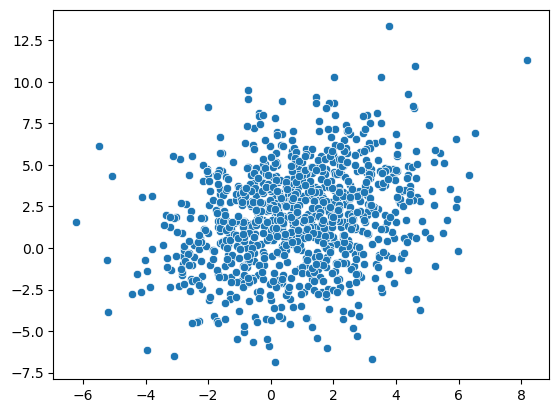

In [221]:
# from matplotlib.patches import Ellipse

# thickness_vars = np.random.normal(scale=demography_df['thickness'].values.std(), size=(demography_df.shape[0], 2))
# thickness_vars = (thickness_vars.T + 1.0 * demography_df['thickness'].values).T

# print(np.corrcoef(thickness_vars.T))

# Sigma_actual = np.cov(thickness_vars.T)
# var, U = np.linalg.eig(Sigma_actual)
# angle = np.arccos(np.abs(U[0, 0]))

# def plot_ellipse(x_center, y_center, x_radius, y_radius, rotation_angle, ax, color='darkorange'):
#     u, v, a, b, t_rot = x_center, y_center, x_radius, y_radius, rotation_angle
    
#     t = np.linspace(0, 2*np.pi, 100)
#     Ell = np.array([a*np.cos(t) , b*np.sin(t)])
#     R_rot = np.array([[np.cos(t_rot) , -np.sin(t_rot)],[np.sin(t_rot) , np.cos(t_rot)]])
#     Ell_rot = R_rot.dot(Ell)
    
#     ax.plot(u + Ell_rot[0,:], v + Ell_rot[1,:], color)
#     ax.fill(u + Ell_rot[0,:], v + Ell_rot[1,:], color, alpha=0.3)

ax = sns.scatterplot(x=vs[:,0], y=vs[:,1])

# plot_ellipse(thickness_vars[:,0].mean(), thickness_vars[:,1].mean(), 2 * np.sqrt(1.96 * var[0]), 2 * np.sqrt(1.96 * var[1]), angle, ax)

# demography_df[['thickness_v1', 'thickness_v2']] = thickness_vars


In [237]:
pm.__version__

'4.2.2'

## Covariance fit

---

A direct covariance fit with pymc seems to be problematic (see [this](https://github.com/pymc-devs/pymc/issues/6461) and [this](https://discourse.pymc.io/t/multivariate-normal-distribution-with-dependent-covariance-and-advi/11219/3) for current attempts to solving the issue).

An alternative approach would be to model linear combinations of the two variable and model covariance by the closed form formula.

In [349]:
# 10 different ways to combine the two measures
combination_weights = np.random.dirichlet([1, 1], size=thickness_vars.shape[0])

# combined_thicknesses = np.multiply(thickness_vars, combination_weights).sum(1)

# demography_df[['combined_thicknesses']] = combined_thicknesses.reshape(-1, 1)


In [550]:
%%time

import aesara.tensor as at

# smaller sample for faster convergence
# sample_df = all_df.sample(200, random_state=1)
sample_df = demography_df

# Data preperation
age = sample_df['age'].values
age_standardized = (age - age.mean()) / age.std()
thickness_v1 = sample_df['thickness_v1'].values
thickness_v1_standardized = (thickness_v1 - thickness_v1.mean()) / thickness_v1.std()
thickness_v2 = sample_df['thickness_v2'].values
thickness_v2_standardized = (thickness_v2 - thickness_v2.mean()) / thickness_v2.std()
thicknesses_standardized = np.concatenate([thickness_v1_standardized[:, np.newaxis], thickness_v2_standardized[:, np.newaxis]], axis=1)
# combined_thicknesses = sample_df['combined_thicknesses'].values
# combined_thicknesses_standardized = (combined_thicknesses - combined_thicknesses.mean()) / combined_thicknesses.std()
# combination_weights = combination_weights
# combined_thicknesses = np.multiply(thicknesses_standardized, combination_weights).sum(1)
site_idxs, sites = pd.factorize(sample_df['dataset'])
sex_idxs, sexes = pd.factorize(sample_df['sex'])
# thickness_idxs, thicknesses = pd.factorize(['thickness_v1','thickness_v2'])

# multiple weights from the same pair
multiplicity = 1000

age_standardized_mult = np.repeat(age_standardized[np.newaxis,:], multiplicity, axis=0).reshape(-1)
sex_idxs_mult = np.repeat(sex_idxs[np.newaxis,:], multiplicity, axis=0).reshape(-1)
site_idxs_mult = np.repeat(site_idxs[np.newaxis,:], multiplicity, axis=0).reshape(-1)

combination_weights_mult = []
combined_thicknesses_mult = []
for i in range(multiplicity):
    # a weight to combine two variables with
    combination_weights = (4*(np.random.uniform(size=thicknesses_standardized.shape) - 0.5))
    combination_weights_mult.append(combination_weights)

    # combine values
    combined_thicknesses = np.multiply(thicknesses_standardized, combination_weights).sum(1)
    combined_thicknesses_mult.append(combined_thicknesses)

combination_weights_mult = np.concatenate(combination_weights_mult)
combined_thicknesses_mult = np.concatenate(combined_thicknesses_mult)
   
# Splines to model nonlinear age effects on thickness
# number of spline nuts (could be tuned)
num_knots = 3
knot_list = np.quantile(age_standardized, np.linspace(0, 1, num_knots))
# create b spline basis for regression using patsy
B_spline_age = patsy.dmatrix(
    "bs(age_standardized, knots=knots, degree=3, include_intercept=True) - 1",
    {"age_standardized": age_standardized_mult, "knots": knot_list[1:-1]},
)

coords = {
    "site": sites,
    "sex": sexes,
    "splines": np.arange(B_spline_age.shape[1]),
    "obs_id": np.arange(len(site_idxs_mult)),
}

advi_model_cov = pm.Model(coords=coords)

# a nonlinear spline model (see https://www.pymc.io/projects/examples/en/latest/case_studies/spline.html)
with advi_model_cov:
    # minibatch variables
    age_standardized_t = pm.Minibatch(age_standardized_mult, 100,)
    sex_idx_t = pm.Minibatch(sex_idxs_mult, 100)
    site_idx_t = pm.Minibatch(site_idxs_mult, 100)
    B_spline_age_t = pm.Minibatch(B_spline_age, 100)
    # thickness_v1_standardized_t = pm.Minibatch(thickness_v1_standardized, 100)
    # thickness_v2_standardized_t = pm.Minibatch(thickness_v2_standardized, 100)
    # thicknesses_standardized_t = pm.Minibatch(thicknesses_standardized, 100)
    combined_thicknesses_t = pm.Minibatch(combined_thicknesses_mult, 100)
    combination_weights_t = pm.Minibatch(combination_weights_mult, 100)
    
    # Hyperpriors for site groups (as if we have random group effects)
    mu_intercept_site_rho = pm.Normal('mu_intercept_site_rho', mu=0, sigma=10)
    sigma_intercept_site_rho = pm.HalfNormal("sigma_intercept_site_rho", sigma=10)
    # sigma_error_site_cov = pm.HalfNormal("sigma_error_site_cov", sigma=10)
    

    # Priors (for covariance/correlation)
    # sex effects (similar to fixed sex effects (intercept only))
    intercept_sex_rho = pm.Normal("intercept_sex_rho", mu=0, sigma=0.1, dims="sex")
    
    # site effects (similar to random site effects (intercept only))
    #a_site = pm.Normal("a_site", mu=mu_a_site, sigma=sigma_a_site, dims="site")
    intercept_site_offset_rho = pm.Normal("intercept_site_offset_rho", mu=0, sigma=0.1, dims="site")
    intercept_site_rho = pm.Deterministic("intercept_site_rho", mu_intercept_site_rho + intercept_site_offset_rho * sigma_intercept_site_rho, dims="site")
    
    # age splines
    w_age_rho = pm.Normal("w_age_rho", mu=0, sigma=0.1, size=B_spline_age.shape[1], dims="splines")
    
    # Estimated covariance/correlation
    z_est = pm.Deterministic("z_est", intercept_sex_rho[sex_idx_t] + intercept_site_rho[site_idx_t] + pm.math.dot(B_spline_age_t, w_age_rho.T))
    # rho_est = pm.Deterministic("rho_est", 2 * pm.math.sigmoid(intercept_sex_rho[sex_idx_t] + intercept_site_rho[site_idx_t] + pm.math.dot(B_spline_age_t, w_age_rho.T)) - 1)
    rho_est = pm.Deterministic("rho_est", 2 * pm.math.sigmoid(z_est) - 1)
    

#     # Model error
#     # nonlinear age error
#     w_error_age_cov = pm.Cauchy("w_error_age_cov", alpha=0, beta=5, size=B_spline_age.shape[1], dims="splines")
    
#     # constant sex error
#     error_sex_cov = pm.Cauchy("error_sex_cov", alpha=0, beta=5, dims="sex")
    
#     # random site error
#     error_site_offset_cov = pm.Cauchy("error_site_offset_cov", alpha=0, beta=5, dims="site")
#     error_site_cov = pm.Deterministic("error_site", error_site_offset_cov * sigma_error_site_cov, dims="site")
    
#     # Error estimate
#     thickness_error_cov = pm.Deterministic("thickness_error", error_sex[sex_idx_t] + error_site[site_idx_t] + pm.math.dot(B_spline_age_t, w_error_age.T))
    

    # Priors (constant priors, already fitted in previous models)
    # sex effects (similar to fixed sex effects (intercept only))
    # intercept_sex = pm.Normal("intercept_sex", mu=0, sigma=10, dims="sex")
    intercept_sex_v1 = pm.ConstantData("intercept_sex_v1", np.array(advi_model_idata_v1.posterior['intercept_sex'].stack(sample=("chain", "draw")).mean('sample')), dims="sex")
    intercept_sex_v2 = pm.ConstantData("intercept_sex_v2", np.array(advi_model_idata_v2.posterior['intercept_sex'].stack(sample=("chain", "draw")).mean('sample')), dims="sex")
    
    # site effects (similar to random site effects (intercept only))
    #a_site = pm.Normal("a_site", mu=mu_a_site, sigma=sigma_a_site, dims="site")
    # intercept_site_offset = pm.Normal("intercept_site_offset", mu=0, sigma=1, dims="site")
    # intercept_site = pm.Deterministic("intercept_site", mu_intercept_site + intercept_site_offset * sigma_intercept_site, dims="site")
    intercept_site_v1 = pm.ConstantData("intercept_site_v1", np.array(advi_model_idata_v1.posterior['intercept_site'].stack(sample=("chain", "draw")).mean('sample')), dims="site")
    intercept_site_v2 = pm.ConstantData("intercept_site_v2", np.array(advi_model_idata_v2.posterior['intercept_site'].stack(sample=("chain", "draw")).mean('sample')), dims="site")
    
    # age splines
    # w_age = pm.Normal("w_age", mu=0, sigma=10, size=B_spline_age.shape[1], dims="splines")
    w_age_v1 = pm.ConstantData("w_age_v1", np.array(advi_model_idata_v1.posterior['w_age'].stack(sample=("chain", "draw")).mean('sample')), dims="splines")
    w_age_v2 = pm.ConstantData("w_age_v2", np.array(advi_model_idata_v2.posterior['w_age'].stack(sample=("chain", "draw")).mean('sample')), dims="splines")
    
    # Estimated thickness
    # thickness_est = pm.Deterministic("thickness_est", intercept_sex[sex_idx_t] + intercept_site[site_idx_t] + pm.math.dot(B_spline_age_t, w_age.T))
    thickness_est_v1 = pm.Deterministic("thickness_est_v1", intercept_sex_v1[sex_idx_t] + intercept_site_v1[site_idx_t] + pm.math.dot(B_spline_age_t, w_age_v1.T))
    thickness_est_v2 = pm.Deterministic("thickness_est_v2", intercept_sex_v2[sex_idx_t] + intercept_site_v2[site_idx_t] + pm.math.dot(B_spline_age_t, w_age_v2.T))

    # Model error
    # nonlinear age error
    # w_error_age = pm.HalfCauchy("w_error_age", beta=5, size=B_spline_age.shape[1], dims="splines")
    w_error_age_v1 = pm.ConstantData("w_error_age_v1", np.array(advi_model_idata_v1.posterior['w_error_age'].stack(sample=("chain", "draw")).mean('sample')), dims="splines")
    w_error_age_v2 = pm.ConstantData("w_error_age_v2", np.array(advi_model_idata_v2.posterior['w_error_age'].stack(sample=("chain", "draw")).mean('sample')), dims="splines")
    
    # constant sex error
    # error_sex = pm.HalfCauchy("error_sex", beta=5, dims="sex")
    error_sex_v1 = pm.ConstantData("error_sex_v1", np.array(advi_model_idata_v1.posterior['error_sex'].stack(sample=("chain", "draw")).mean('sample')), dims="sex")
    error_sex_v2 = pm.ConstantData("error_sex_v2", np.array(advi_model_idata_v2.posterior['error_sex'].stack(sample=("chain", "draw")).mean('sample')), dims="sex")
    
    # random site error
    # error_site_offset = pm.HalfCauchy("error_site_offset", beta=5, dims="site")
    # error_site = pm.Deterministic("error_site", error_site_offset * sigma_error_site, dims="site")
    error_site_v1 = pm.ConstantData("error_site_v1", np.array(advi_model_idata_v1.posterior['error_site'].stack(sample=("chain", "draw")).mean('sample')), dims="site")
    error_site_v2 = pm.ConstantData("error_site_v2", np.array(advi_model_idata_v2.posterior['error_site'].stack(sample=("chain", "draw")).mean('sample')), dims="site")
    
    # Error estimate
    # thickness_error = pm.Deterministic("thickness_error", error_sex[sex_idx_t] + error_site[site_idx_t] + pm.math.dot(B_spline_age_t, w_error_age.T))
    thickness_error_v1 = pm.Deterministic("thickness_error_v1", error_sex_v1[sex_idx_t] + error_site_v1[site_idx_t] + pm.math.dot(B_spline_age_t, w_error_age_v1.T))
    thickness_error_v2 = pm.Deterministic("thickness_error_v2", error_sex_v2[sex_idx_t] + error_site_v2[site_idx_t] + pm.math.dot(B_spline_age_t, w_error_age_v2.T))
        
    # Likelihood (sampling distribution) of observations
    # Likelihood estimation from a bivariate normal with known mean and variance, but unknown covariance
    combined_mu = pm.Deterministic("combined_mu", pm.math.sum(at.math.mul(combination_weights_t, at.stacklists([thickness_est_v1, thickness_est_v2]).T), axis=1))
    combined_sigma = pm.Deterministic("combined_sigma", at.math.mul(combination_weights_t, at.stacklists([thickness_error_v1, thickness_error_v2]).T))

    # corr_est = pm.Deterministic("corr_est", at.stacklists([[1, rho_est], [rho_est, 1]]))
    
    combined_var = pm.Deterministic("combined_var", pm.math.sqrt(combined_sigma[:, 0]**2 + combined_sigma[:, 1]**2 + 2 * combined_sigma[:, 0] * combined_sigma[:, 1] * rho_est))
    
    # bivariate_mu = pm.Deterministic("bivariate_mu", at.stacklists([thickness_est_v1, thickness_est_v2]).T)
    # covariance_matrix = pm.Deterministic(
    #     "covariance_matrix",
    #     at.stacklists([[thickness_error_v1, cov_est], [cov_est, thickness_error_v2]]).T
    # )
    # instead of a covariance matrix, let's define a cholesky decomposition
    # see:
    # https://www.pymc.io/projects/docs/en/stable/api/distributions/generated/pymc.LKJCholeskyCov.html
    # https://www2.stat.duke.edu/courses/Spring12/sta104.1/Lectures/Lec22.pdf
    # cholesky_decomposition = pm.Deterministic("cholesky_decomposition", at.stacklists([thickness_est_v1, at.math.mul(thickness_est_v2, rho_est), at.math.mul(thickness_est_v2, at.math.sqrt(1 - rho_est**2)),]).T)
    
    # MvNormal only accept one cov at a time, you need to construct 
    # each component one by one
    # (check https://discourse.pymc.io/t/mixed-multivariate-gauss-distribution/1017/3)
    
#     compdist = []
#     for i in range(100):
#         compdist.append(
#             pm.MvNormal.dist(
#                 mu=bivariate_mu[i], cov=covariance_matrix[i]
#             )
#         )

#     obs = pm.Mixture('likelihood', w, compdist, observed=dataSet1)
    
    # likelihood = pm.MvNormal(
    likelihood = pm.Normal(
        "likelihood",
        mu=combined_mu,
        sigma=combined_var,
        observed=combined_thicknesses_t,
        total_size=len(sample_df) * multiplicity,
    )
        # cov=covariance_matrix,
    print('model defined!')
        
    # run ADVI with minibatch
    error_approx_cov = pm.fit(100000, callbacks=[pm.callbacks.CheckParametersConvergence(tolerance=1e-4)])
    print('advi executed!')
    
    # sample from trace
    advi_model_idata_cov = pm.sample_prior_predictive()
    advi_model_idata_cov.extend(error_approx_cov.sample(2000))
    pm.sample_posterior_predictive(advi_model_idata_cov, extend_inferencedata=True)


model defined!


Finished [100%]: Average Loss = 147.21


advi executed!


Sampling: [intercept_sex_rho, intercept_site_offset_rho, likelihood, mu_intercept_site_rho, sigma_intercept_site_rho, w_age_rho]
/mountpoint/code/environments/pymc_env/lib/python3.10/site-packages/pymc/backends/arviz.py:56: UserWarning: Could not extract data from symbolic observation likelihood
  warnings.warn(f"Could not extract data from symbolic observation {obs}")
/mountpoint/code/environments/pymc_env/lib/python3.10/site-packages/pymc/backends/arviz.py:56: UserWarning: Could not extract data from symbolic observation likelihood
  warnings.warn(f"Could not extract data from symbolic observation {obs}")
Sampling: [likelihood]


CPU times: user 1min 27s, sys: 661 ms, total: 1min 28s
Wall time: 1min 27s


/mountpoint/code/environments/pymc_env/lib/python3.10/site-packages/pymc/backends/arviz.py:56: UserWarning: Could not extract data from symbolic observation likelihood
  warnings.warn(f"Could not extract data from symbolic observation {obs}")


In [358]:
np.corrcoef(thicknesses_standardized.T)

array([[1.        , 0.49607582],
       [0.49607582, 1.        ]])

In [284]:
advi_model_idata_cov

Inference data with groups:
	> posterior
	> posterior_predictive
	> prior
	> constant_data

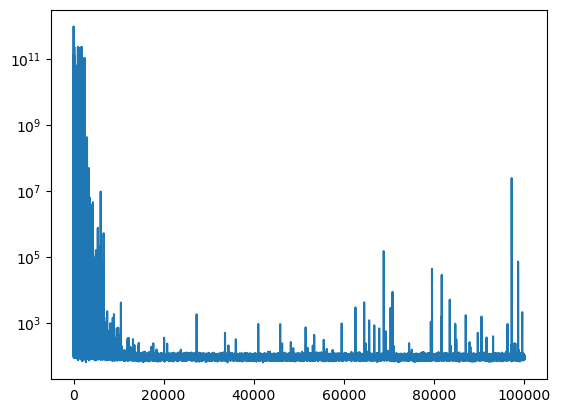

In [352]:
plt.plot(error_approx_cov.hist[:100000])

ax = plt.gca()
ax.set_yscale('log')

CPU times: user 420 ms, sys: 434 ms, total: 854 ms
Wall time: 78.2 ms


(-1.0, 1.0)

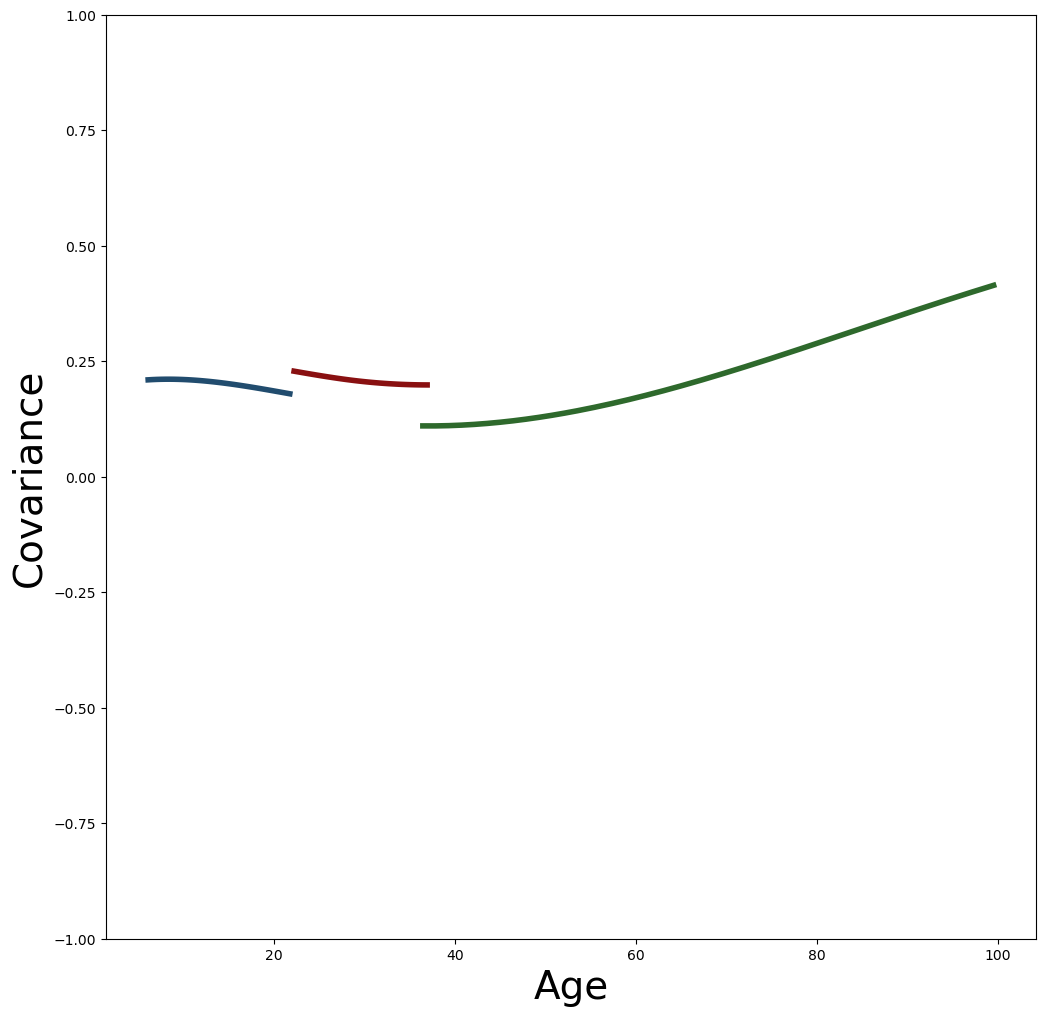

In [552]:
%%time

fig, ax = plt.subplots(1, 1, figsize=(12, 12))

sigmoid = lambda x: 1/(1 + np.exp(-x))

# sns.scatterplot(
#     data=demography_df,
#     x='age',
#     y='thickness_v2',
#     ax=ax,
#     linewidth=0,
#     hue='dataset',
#     palette="Set1",
# #     palette=mpl.cm.Set1,
#     alpha = 0.3,
# #     color=[0.3,0.6,0.9,0.5],
# )

# ax.set_xlim(20,40)
# ax.set_ylim(2.2,3)

ax.set_xlabel('Age', fontsize=28)
ax.set_ylabel('Covariance', fontsize=28)

# thickness = sample_df['thickness_v2'].values

for idx in np.unique(site_idxs):
    xi = xr.DataArray(np.linspace(np.min(age), np.max(age), 200), dims=["obs_id"])
    selection = (xi > np.min(age[site_idxs == idx])) & (xi < np.max(age[site_idxs == idx]))
    post = advi_model_idata_cov.posterior
    
    prediction_B_spline_age = patsy.dmatrix(
        "bs(xi, knots=knots, degree=3, include_intercept=True) - 1",
        {"xi": ((xi - age.mean()) / age.std()), "knots": knot_list[1:-1]},
    )

    y_ppc_mu = (
        post['intercept_sex_rho'].stack(sample=("chain", "draw"))[0].data +
        post['intercept_site_rho'].stack(sample=("chain", "draw"))[idx].data +
        np.dot(
            prediction_B_spline_age,
            post['w_age_rho'].stack(sample=("chain", "draw"))
        )
    )

#     y_ppc_sigma = (
#         post['error_sex'].stack(sample=("chain", "draw"))[0].data +
#         post['error_site'].stack(sample=("chain", "draw"))[idx].data +
#         np.dot(
#             prediction_B_spline_age,
#             post['w_error_age'].stack(sample=("chain", "draw"))
#         )
#     )

    # y_ppc_alpha = post['thickness_skewness'].stack(sample=("chain", "draw")).data
    
    # need to ensure the correctness
    quantiles = [0.50,]
    # quantiles = [0.01, 0.05, 0.25, 0.50, 0.75, 0.95, 0.99]
    
    # thickness_quantiles = {
    #     q: (
    #         (
    #             y_ppc_mu.mean(1) + stats.norm.ppf(q=q) * y_ppc_sigma.mean(1)
    #         )  * thickness.std() +
    #         thickness.mean()
    #     ) for q in quantiles
    # }

#     # centile plot
#     for q1, q2, alpha in [(0.01, 0.99, 0.1), (0.05, 0.95, 0.3), (0.25, 0.75, 0.5)]:
#         ax.fill_between(
#             xi[selection],
#             thickness_quantiles[q1][selection],
#             thickness_quantiles[q2][selection],
#             alpha=alpha,
#             color=np.array(mpl.cm.Set1(idx)[:3])*0.8,
#         )
    
    ax.plot(
        xi[selection],
        (2 * sigmoid(y_ppc_mu.mean(1)) - 1)[selection],
        c=np.array(mpl.cm.Set1(idx)[:3])*0.6,
        lw=4,
    )

ax.set_ylim([-1,1])

In [562]:
import pymc as pm
import aesara.tensor as at

data_count = 3000

c1 = np.random.uniform(size = data_count)

mus = np.array([1, 2])
sigmas = np.diag([2, 3])

vs = []
for x in range(data_count):
    c = (c1[x] * 1.6 - 0.8) ** 2 + 0.2
    rho = np.array([[1, c], [c, 1]])
    cov = sigmas.dot(rho.dot(sigmas))
    vs.append(np.random.multivariate_normal(mus, cov, size=1))

vs = np.concatenate(vs)

v1 = vs[:, 0]
v2 = vs[:, 1]

# first, standardize all variables to center the distributions around zero
v1_standardized = (v1 - v1.mean()) / v1.std()
v2_standardized = (v2 - v2.mean()) / v2.std()
vs_standardized = np.concatenate([v1_standardized[:, np.newaxis], v2_standardized[:, np.newaxis]], axis=1)
c1_standardized = (c1 - c1.mean()) / c1.std()

# multiple weights from the same pair
multiplicity = 1000

c1_standardized_mult = np.repeat(c1_standardized[np.newaxis,:], multiplicity, axis=0).reshape(-1)

ws_mult = []
combined_vs_mult = []
for i in range(multiplicity):
    # a weight to combine two variables with
    ws = (4*(np.random.uniform(size=vs_standardized.shape) - 0.5))
    ws_mult.append(ws)

    # combine values
    combined_vs = np.multiply(vs_standardized, ws).sum(1)
    combined_vs_mult.append(combined_vs)

ws_mult = np.concatenate(ws_mult)
combined_vs_mult = np.concatenate(combined_vs_mult)
    
# Splines to model nonlinear effects of c1
# number of spline nuts (could be tuned)
num_knots = 3
knot_list = np.quantile(c1_standardized, np.linspace(0, 1, num_knots))
# create b spline basis for regression using patsy
B_spline_c1 = patsy.dmatrix(
    "bs(c1_standardized, knots=knots, degree=3, include_intercept=True) - 1",
    {"c1_standardized": c1_standardized_mult, "knots": knot_list[1:-1]},
)

coords = {
    "splines": np.arange(B_spline_age.shape[1]),
    "obs_id": np.arange(len(v1_standardized)),
}

advi_model_cov = pm.Model(coords=coords)

with advi_model_cov:
    batch_size = 128
    # minibatch variables
    c1_standardized_t = pm.Minibatch(c1_standardized_mult, batch_size,)
    B_spline_c1_t = pm.Minibatch(B_spline_c1, batch_size)
    # vs_standardized_t = pm.Minibatch(vs_standardized, batch_size)
    ws_t = pm.Minibatch(ws_mult, batch_size)
    combined_vs_t = pm.Minibatch(combined_vs_mult, batch_size)

    # Priors (for covariance)
    
    # constant offset
    offset_rho = pm.Normal('offset_rho', mu=0, sigma=10)

    # c1 splines
    w_c1_rho = pm.Normal("w_c1_cov", mu=0, sigma=10, size=B_spline_c1.shape[1], dims="splines")

    # Estimated covariance
    rho_est = pm.Deterministic("rho_est", 2 * pm.math.sigmoid(offset_rho + pm.math.dot(B_spline_c1_t, w_c1_rho.T)) - 1 )

    # Priors (constant priors, already given)

    # Estimated means
    est_v1 = pm.MutableData("est_v1", np.repeat(mus[0] - v1.mean(), batch_size))
    est_v2 = pm.MutableData("est_v2", np.repeat(mus[1] - v2.mean(), batch_size))

    # Model variance

    # Variance estimate
    std_v1 = pm.MutableData("var_v1", np.repeat(sigmas[0, 0] / v1.std(), batch_size))
    std_v2 = pm.MutableData("var_v2", np.repeat(sigmas[1, 1] / v2.std(), batch_size))

    
    # Likelihood estimation from a bivariate normal with known mean and variance, but unknown covariance
    combined_mu = pm.Deterministic("combined_mu", pm.math.sum(at.math.mul(ws_t, at.stacklists([est_v1, est_v2]).T), axis=1))
    combined_sigma = pm.Deterministic("combined_sigma", at.math.mul(ws_t, at.stacklists([std_v1, std_v2]).T))
    combined_var = pm.Deterministic("combined_var", pm.math.sqrt(combined_sigma[:, 0]**2 + combined_sigma[:, 1]**2 + 2 * combined_sigma[:, 0] * combined_sigma[:, 1] * rho_est))

    
    likelihood = pm.Normal(
        "likelihood",
        mu=combined_mu,
        sigma=combined_var,
        observed=combined_vs_t,
        total_size=data_count * multiplicity,
    )
    
#     # Construct the mean vector and covariance matrix for MvNormal to fit a bivariate normal
#     bivariate_mu = pm.Deterministic("bivariate_mu", at.as_tensor_variable([est_v1, est_v2]).T)
#     cholesky_decomposition = pm.Deterministic("cholesky_decomposition", at.as_tensor_variable([var_v1, at.math.mul(var_v2, rho_est), at.math.mul(var_v2, at.math.sqrt(1 - rho_est**2)),]).T)

#     # Likelihood estimation from a bivariate normal with known mean and variance, but unknown covariance
#     likelihood = pm.MvNormal(
#         "likelihood",
#         mu=bivariate_mu,
#         chol=cholesky_decomposition,
#         observed=vs_standardized_t,
#         total_size=len(v1_standardized),
#     )
    
    # run ADVI with minibatch
    approx_cov = pm.fit(100000, callbacks=[pm.callbacks.CheckParametersConvergence(tolerance=1e-4)])

    # sample from trace
    advi_model_idata_cov = pm.sample_prior_predictive()
    advi_model_idata_cov.extend(approx_cov.sample(2000))
    pm.sample_posterior_predictive(advi_model_idata_cov, extend_inferencedata=True)

Finished [100%]: Average Loss = 218.09
Sampling: [likelihood, offset_rho, w_c1_cov]
/mountpoint/code/environments/pymc_env/lib/python3.10/site-packages/pymc/backends/arviz.py:56: UserWarning: Could not extract data from symbolic observation likelihood
  warnings.warn(f"Could not extract data from symbolic observation {obs}")
/mountpoint/code/environments/pymc_env/lib/python3.10/site-packages/pymc/backends/arviz.py:56: UserWarning: Could not extract data from symbolic observation likelihood
  warnings.warn(f"Could not extract data from symbolic observation {obs}")
Sampling: [likelihood]


/mountpoint/code/environments/pymc_env/lib/python3.10/site-packages/pymc/backends/arviz.py:56: UserWarning: Could not extract data from symbolic observation likelihood
  warnings.warn(f"Could not extract data from symbolic observation {obs}")


[[1.         0.42594044]
 [0.42594044 1.        ]]


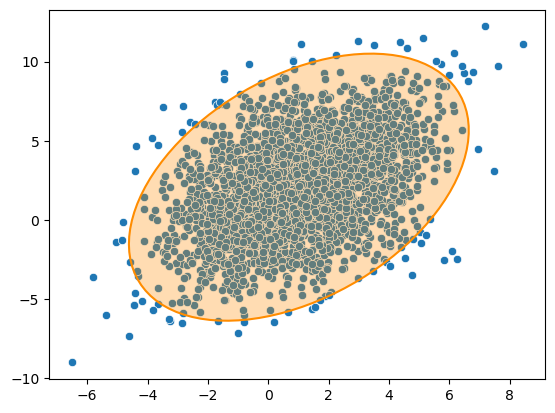

In [563]:
print(np.corrcoef(vs.T))

Sigma_actual = np.cov(vs.T)
var, U = np.linalg.eig(Sigma_actual)
angle = -np.arccos(np.abs(U[0, 0]))

ax = sns.scatterplot(x=vs[:,0], y=vs[:,1])

plot_ellipse(vs[:,0].mean(), vs[:,1].mean(), 2 * np.sqrt(1.96 * var[0]), 2 * np.sqrt(1.96 * var[1]), angle, ax)


CPU times: user 116 ms, sys: 112 ms, total: 227 ms
Wall time: 33.2 ms


(-1.0, 1.0)

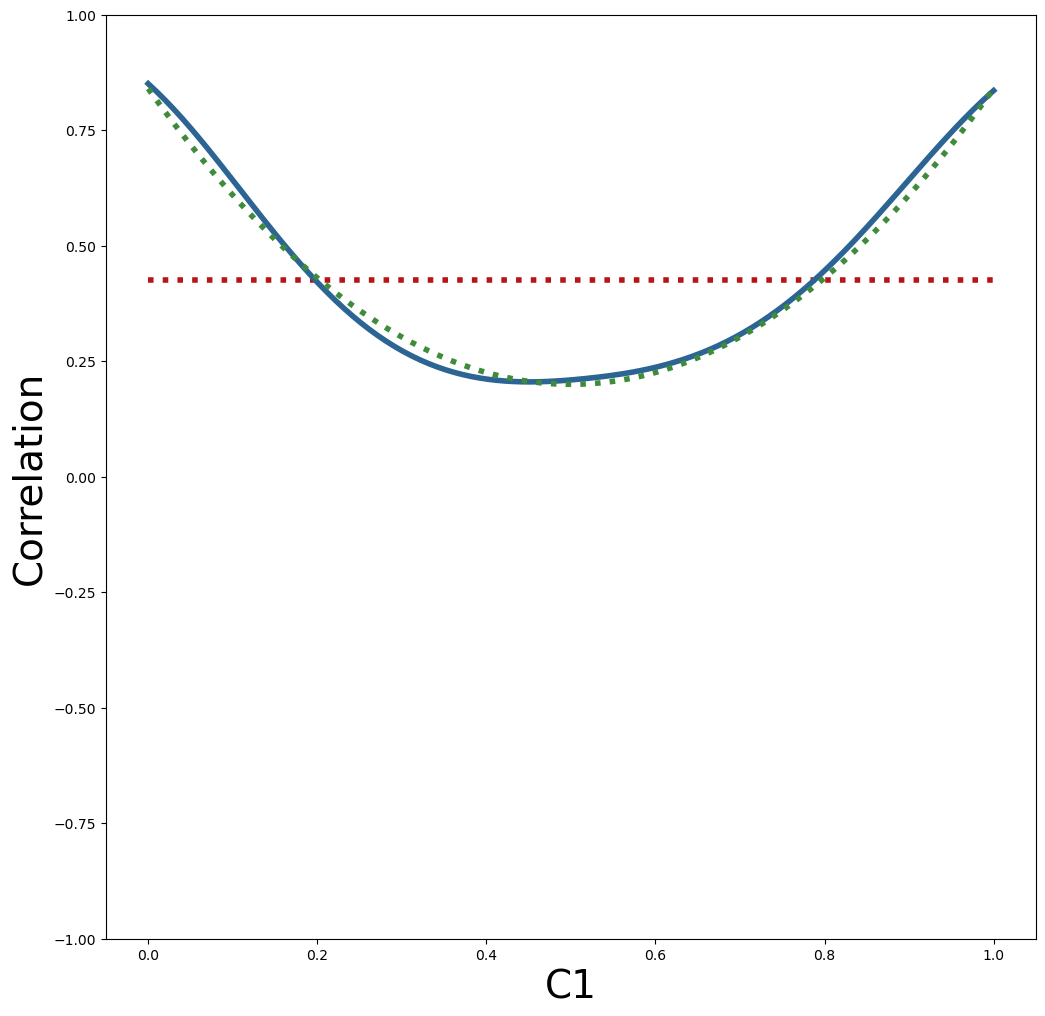

In [569]:
%%time

fig, ax = plt.subplots(1, 1, figsize=(12, 12))

sigmoid = lambda x: 1/(1 + np.exp(-x))

# sns.scatterplot(
#     data=demography_df,
#     x='age',
#     y='thickness_v2',
#     ax=ax,
#     linewidth=0,
#     hue='dataset',
#     palette="Set1",
# #     palette=mpl.cm.Set1,
#     alpha = 0.3,
# #     color=[0.3,0.6,0.9,0.5],
# )

# ax.set_xlim(20,40)
# ax.set_ylim(2.2,3)

ax.set_xlabel('C1', fontsize=28)
ax.set_ylabel('Correlation', fontsize=28)

# thickness = sample_df['thickness_v2'].values

# xi = xr.DataArray(np.linspace(np.min(c1), np.max(c1), 200), dims=["obs_id"])
xi = xr.DataArray(np.linspace(0, 1, 200), dims=["obs_id"])
post = advi_model_idata_cov.posterior

prediction_B_spline_c1 = patsy.dmatrix(
    "bs(xi, knots=knots, degree=3, include_intercept=True) - 1",
    {"xi": ((xi - c1.mean()) / c1.std()), "knots": knot_list[1:-1]},
)

y_ppc_mu = (
    post['offset_rho'].stack(sample=("chain", "draw")).data +
    np.dot(
        prediction_B_spline_c1,
        post['w_c1_cov'].stack(sample=("chain", "draw"))
    )
)

ax.hlines(np.corrcoef(vs.T)[0,1], 0, 1, color=np.array(mpl.cm.Set1(0)[:3])*0.8, lw=4, linestyle=":")
ax.plot(
    xi,
    (2 * sigmoid(y_ppc_mu.mean(1)) - 1),
    c=np.array(mpl.cm.Set1(1)[:3])*0.8,
    lw=4,
)
ax.plot(
    xi,
    (xi * 1.6 - 0.8)**2 + 0.2,
    c=np.array(mpl.cm.Set1(2)[:3])*0.8,
    lw=4,
    linestyle=':',
)

ax.set_ylim([-1,1])

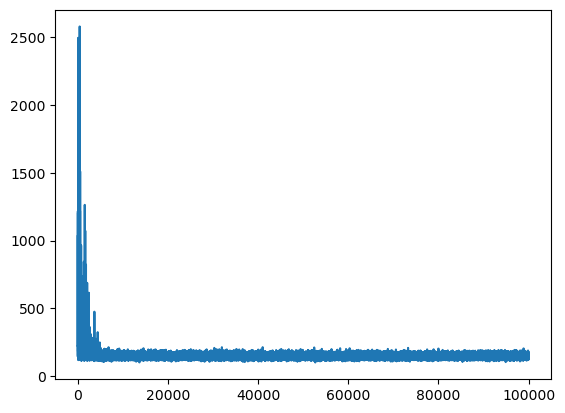

In [437]:
plt.plot(approx_cov.hist)